# DNN 实现 逻辑回归

## 1. 生成一个用于逻辑回归测试的数据

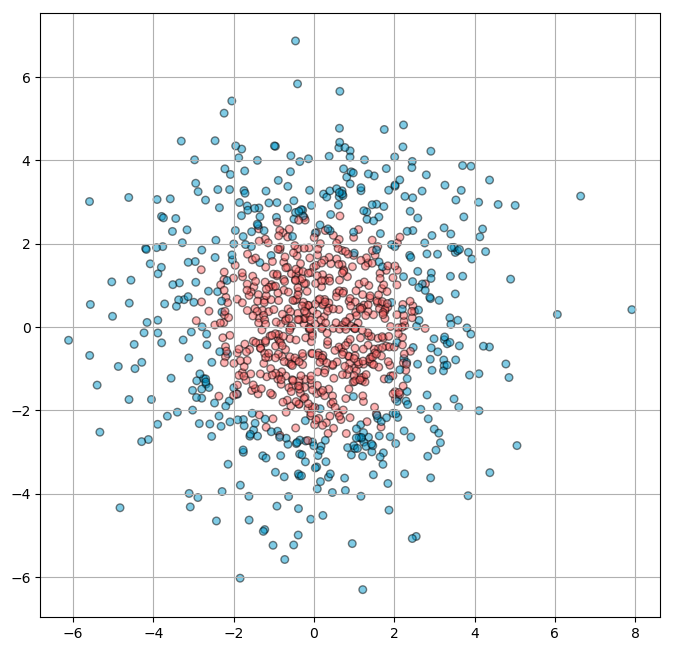

(1, 1000)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def dataTF(m=1000):
#   np.random.seed(...)  保证每次输出结果不变。
    np.random.seed(1)
    X = 2*np.random.randn(2,m)
#   很方便的求 2-范数 的方法（相当于求半径）
    R = np.linalg.norm(X,ord=2,axis=0).reshape(1,m)
#   增加一个噪音
    np.random.seed(2)
    noise = .3 * np.random.normal(size=R.shape)
    R = R + noise
#   二值化输出
    Y = np.int32(np.array(R < 2.5))    
#     Y = np.squeeze(Y)
    return X,Y
#   合并输入输出数据 （学会用 np.r_[...] 和 np.c_[...])
#     X = np.r_[X,Y]

def plotClassify(X,Y,cmap=['#0099CC', '#FF6666']):
    plt.figure(figsize=(8,8),dpi=100)
    plt.grid(True)
    cm_light = ListedColormap(cmap)
    Y = np.squeeze(Y)
    plt.scatter(X[0], X[1], s=30, c=Y, edgecolors='k', cmap=cm_light,alpha=0.5)
    plt.show()
    
X,Y = dataTF()
plotClassify(X,Y)
print(Y.shape)

## 2. 为 DNN 准备好逻辑回归用得着的  代价函数、激活函数、高级字典 Ea

In [2]:
# 高级字典 Ea
from collections import defaultdict
class Ea(defaultdict):
    def __init__(self):
        super(Ea,self).__init__()

    def __getattr__(self, name):
        if name in self:
            if self[name] is None:
                return ""
            return self[name]
        n = Ea()
        super(Ea, self).__setitem__(name, n)
        return n

    def __setattr__(self, name, value):
        super(Ea, self).__setitem__(name, value)

    def __getitem__(self, name):
        if name not in self:
            super(Ea, self).__setitem__(name, Ea())
        return super(Ea, self).__getitem__(name)
        
def L2(A, Y):
    loss = 1/2 * np.dot((A-Y), (A-Y).T)
    loss = np.squeeze(loss)
    return loss

def dL2(A,Y):
    return A-Y

def L3(A, Y):
    m = Y.shape[1]
    loss = -1 / m * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A), axis=1, keepdims=True)
    loss = np.squeeze(loss)
    assert (loss.shape == ())
    return loss

def dL3(A,Y):
    loss = -Y/A + (1-Y)/(1-A)
    loss = np.squeeze(loss)
    return loss

def relu(z):
    g = np.fmax(z, 0)
    return g

def dz_relu(z):
    g = np.fmax(z,0)
    g = np.sign(g)
    return g

def leaky_relu(z):
    g = np.fmax(z, 0.01*z)
    return g

def dz_leaky_relu(z):
    g = np.piecewise(z, [z < 0, z > 0], [.01, 1])
    return g

def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

def dz_sigmoid(z):
    s = sigmoid(z)
    dz = s * (1-s)
    return dz

## 3. 实现DNN初始化参数和迭代方法

In [3]:
# DNN 网络 随机初始化 W, b
def dnnInitWb(L, n):
    W = Ea()
    b = Ea()
    p = 0.2
    for l in range(1, L + 1):
        np.random.seed(2)
        W[l] = np.random.normal(size=(n[l], n[l - 1])) * p
        b[l] = np.zeros(shape=(n[l], 1))
    return W,b

# DNN 网络 根据网络模型，预测结果
def dnnPredict(model, X):
    L = model.L 
    W = model.W 
    b = model.b 
    g = model.g
    A = Ea()
    A[0] = X
    Z = Ea()

    for l in range(1, L + 1):
        Z[l] = np.dot(W[l], A[l - 1]) + b[l]
        A[l] = g[l](Z[l])
    yhat = A[L]
    yhat = np.int32(np.array(yhat > 0.5))
    return yhat
    

# DNN 网络 迭代
def dnnFit(X,Y,L,W,b,g,dg,J,dJ,learn_rate=0.02,max_itr=5000,tg=0.0001):
    # max_itr: 最大迭代次数
    # tg: 梯度截断参数
    output_cost = []

    A=Ea()
    A[0]=X
    dA = Ea()
    dZ = Ea()
    dW = Ea()
    db = Ea()
    Z=Ea()

    break_flag = 0
    old_cost = 0

    for i in range(1, max_itr):
        # forward properation
        for l in range(1, L + 1):
            Z[l] = np.dot(W[l], A[l - 1]) + b[l]
            A[l] = g[l](Z[l])

        cost = J(A[L], Y)
        # print(cost)
        dA[L] = dJ(A[L], Y)
        output_cost.append(cost)
        if old_cost - cost < tg * output_cost[0]:
            break_flag += 1

        old_cost = cost

        # back properation
        for l in range(0, L):
            l = L - l
            _dg = dg[l](Z[l])
            dZ[l] = _dg * dA[l]
            dA[l - 1] = np.dot(W[l].T, dZ[l])
            dW[l] = 1 / X.shape[1] * np.dot(dZ[l], A[l - 1].T)
            db[l] = 1 / X.shape[1] * np.sum(dZ[l], axis=1, keepdims=True)

        # update parameters
        for l in range(0, L):
            l = L - l
            W[l] = W[l] - learn_rate * dW[l]
            b[l] = b[l] - learn_rate * db[l]

        if break_flag > 30:
            break
            
    model = Ea()
    model.L = L
    model.W = W
    model.b = b
    model.g = g
    
    return model, np.squeeze(output_cost)

## 3. 初始化超级参数

In [4]:
L=2 # 或 L=3 试试
n=[0,20,4,1] # 定义每层神经节点个数
n[0] = X.shape[0]
n[L] = 1 # 前置输出层一个节点

g = Ea() # 定义激活函数
g[1] = relu
g[2] = relu
g[L] = sigmoid

dg = Ea() # 定义激活导函数
dg[1] = dz_relu
dg[2] = dz_relu
dg[L] = dz_sigmoid

J = L3 #定义 代价函数 (试试 L2)
dJ = dL3 #定义 代价导函数 (试试 dL2)

## 4. DNN 跑数据，训练模型

In [5]:
# 随机初始化 DNN Wb 参数
W, b = dnnInitWb(L, n)
# DNN 训练模型
model, costs = dnnFit(X, Y, L, W, b, g, dg, J, dJ, 0.1, max_itr=100000, tg=0.00001)
# 注意：学习率要设高一些，否则学习会非常的慢
# 输出模型最终 代价值
print(costs[-1])

0.152754771297


## 5. 检查错误率

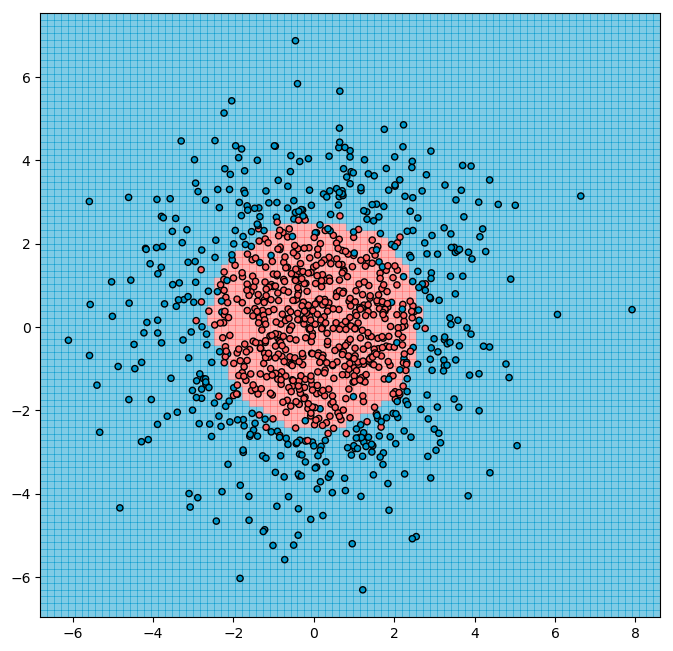

In [6]:
def plotPredict(model,X,Y,cmap=['#0099CC', '#FF6666']):
    # get x_show
    def extend(a, b):
        return 1.05 * a - 0.05 * b, 1.05 * b - 0.05 * a
    x1_min, x1_max = extend(X[0].min(), X[0].max())  # x1的范围
    x2_min, x2_max = extend(X[1].min(), X[1].max())  # x2的范围
    
    N = 90; M = 90
    t1 = np.linspace(x1_min, x1_max, N)
    t2 = np.linspace(x2_min, x2_max, M)
    x1, x2 = np.meshgrid(t1, t2)
    x_show = np.stack((x1.flat, x2.flat), axis=0)
    
    # predict x_show
    y_hat = dnnPredict(model,x_show)
    y_hat = y_hat.reshape(x1.shape) 
    
    plt.figure(figsize=(8,8),dpi=100,facecolor='w')
    cm_light = ListedColormap(cmap)
    plt.pcolormesh(x1, x2, y_hat, cmap=cm_light, alpha=0.5)
    
    Y = np.squeeze(Y)
    plt.scatter(X[0], X[1], s=20, c=Y, edgecolors='k', cmap=cm_light)
    
    plt.show()
    
plotPredict(model,X,Y)

## 6. 绘制逻辑回归损失函数

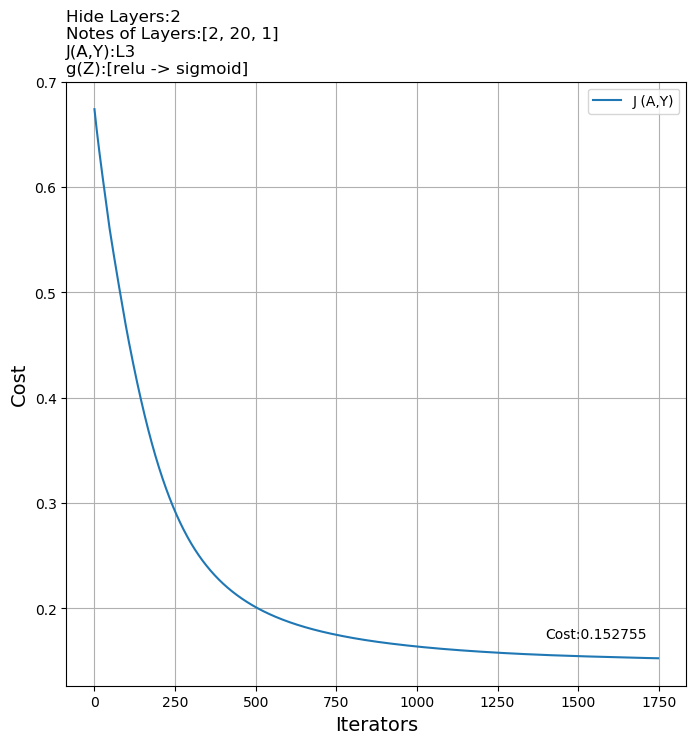

In [7]:
def plotCost(model,J,costs):
    g_names = []
    for l in range(1,model.L+1):
        g_names.append(model.g[l].__name__)

    plt.figure(figsize=(8,8),dpi=100,facecolor='w')
    plt.title("Hide Layers:%d \n" \
              "Notes of Layers:[%s] \n" \
              "J(A,Y):%s \n" \
              "g(Z):[%s]" % (model.L,
                             ", ".join(map(str,n[0:model.L+1])),
                             J.__name__,
                             " -> ".join(g_names)),loc='left')
    plt.grid(True)
    wd = len(costs)
    plt.plot(range(0, len(costs)), costs, label='J (A,Y)')
    plt.ylabel("Cost", fontsize=14)
    plt.xlabel("Iterators", fontsize=14)
    plt.text(wd * .8, (costs[0]-costs[-1]) * .33, "Cost:%f" % costs[-1])
    plt.legend()
    plt.show()

plotCost(model,J,costs)